In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('resale-flat-prices/resale-flat-prices-based-on-registration-date-from-jan-2017-onwards.csv', \
                   thousands=',')
#data.values[0]

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58154 entries, 0 to 58153
Data columns (total 11 columns):
month                  58154 non-null object
town                   58154 non-null object
flat_type              58154 non-null object
block                  58154 non-null object
street_name            58154 non-null object
storey_range           58154 non-null object
floor_area_sqm         58154 non-null float64
flat_model             58154 non-null object
lease_commence_date    58154 non-null int64
remaining_lease        58154 non-null object
resale_price           58154 non-null float64
dtypes: float64(2), int64(1), object(8)
memory usage: 4.9+ MB


<h3>Data Prep</h3>

In [5]:
month_unix = pd.to_datetime(data['month'], format='%Y-%m').astype(int) / 10**9

town = data['town']
town_one_hot = pd.get_dummies(town,prefix='town')

flat_type = data['flat_type']
flat_type_one_hot = pd.get_dummies(flat_type,prefix='flat_type')


storey_range_one_hot = pd.get_dummies(data['storey_range'],prefix='storey_range')

flat_model_one_hot = pd.get_dummies(data['flat_model'], prefix='flat_model')

remaining_lease_yrs =  data.remaining_lease.str.slice(0, 2).astype(int)

In [6]:
oh1 = pd.concat([month_unix,town_one_hot],axis=1,sort=False)
oh2 = pd.concat([oh1,flat_type_one_hot],axis=1,sort=False)
oh3 = pd.concat([oh2,storey_range_one_hot],axis=1,sort=False)
oh4 = pd.concat([oh3,data['floor_area_sqm']],axis=1,sort=False)
oh5 = pd.concat([oh4,flat_model_one_hot],axis=1,sort=False)
oh = pd.concat([oh5, remaining_lease_yrs], axis=1, sort=False)
oh.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58154 entries, 0 to 58153
Data columns (total 72 columns):
month                                58154 non-null float64
town_ANG MO KIO                      58154 non-null uint8
town_BEDOK                           58154 non-null uint8
town_BISHAN                          58154 non-null uint8
town_BUKIT BATOK                     58154 non-null uint8
town_BUKIT MERAH                     58154 non-null uint8
town_BUKIT PANJANG                   58154 non-null uint8
town_BUKIT TIMAH                     58154 non-null uint8
town_CENTRAL AREA                    58154 non-null uint8
town_CHOA CHU KANG                   58154 non-null uint8
town_CLEMENTI                        58154 non-null uint8
town_GEYLANG                         58154 non-null uint8
town_HOUGANG                         58154 non-null uint8
town_JURONG EAST                     58154 non-null uint8
town_JURONG WEST                     58154 non-null uint8
town_KALLANG/WHAMPO

In [7]:
train_x, test_x, train_y, test_y = train_test_split(oh.values, data['resale_price'].values, test_size = 0.2, random_state = 0)


In [8]:
print("train_x: ",train_x.shape)
print("test_x: ",test_x.shape)
print("train_y: ",train_y.shape)
print("test_y: ",test_y.shape)

train_x:  (46523, 72)
test_x:  (11631, 72)
train_y:  (46523,)
test_y:  (11631,)


In [16]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(72,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1))

In [18]:
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

In [19]:
EPOCHS = 10
history = model.fit(train_x, train_y, validation_split=0.2, epochs=EPOCHS, shuffle=True)

Train on 37218 samples, validate on 9305 samples
Epoch 1/10
37218/37218 [==============================] - 3s 71us/sample - loss: 36174782025344.7891 - mean_absolute_error: 5213154.5000 - val_loss: 19319462072108.2656 - val_mean_absolute_error: 4391821.5000
Epoch 2/10
37218/37218 [==============================] - 2s 57us/sample - loss: 17695711456133.8945 - mean_absolute_error: 4191040.2500 - val_loss: 11340000553466.0020 - val_mean_absolute_error: 3363212.5000
Epoch 3/10
37218/37218 [==============================] - 2s 56us/sample - loss: 10142226227479.5391 - mean_absolute_error: 3160603.7500 - val_loss: 5157790732060.4199 - val_mean_absolute_error: 2265203.5000
Epoch 4/10
37218/37218 [==============================] - 2s 56us/sample - loss: 5669918626850.9424 - mean_absolute_error: 2370657.2500 - val_loss: 4068963132454.6270 - val_mean_absolute_error: 2010653.3750
Epoch 5/10
37218/37218 [==============================] - 2s 56us/sample - loss: 4283176053273.3955 - mean_absolute_er

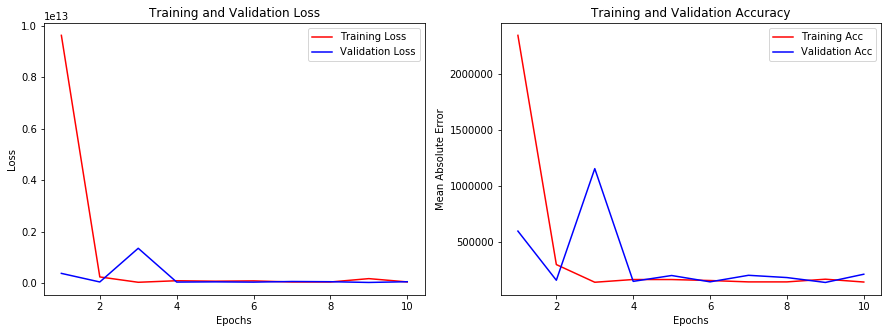

In [15]:
import matplotlib.pyplot as plt
history_dict = history.history
 
fig, (p1, p2) = plt.subplots(1, 2, figsize=(15,5))
 
x = range(1, EPOCHS+1)
 
p1.plot(x, history_dict['loss'], 'r', label='Training Loss')
p1.plot(x, history_dict['val_loss'], 'b', label='Validation Loss')
p1.set_title('Training and Validation Loss')
p1.set_xlabel('Epochs')
p1.set_ylabel('Loss')
p1.legend()
 
p2.plot(x, history_dict['mean_absolute_error'], 'r', label='Training Acc')
p2.plot(x, history_dict['val_mean_absolute_error'], 'b', label='Validation Acc')
p2.set_title('Training and Validation Accuracy')
p2.set_xlabel('Epochs')
p2.set_ylabel('Mean Absolute Error')
p2.legend()
 
plt.show()

In [20]:
from tensorflow.keras import regularizers
 
# L1 Regularization
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.01), input_shape=(72,)))
model.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l1(0.01)))
model.add(layers.Dense(1))
 
# Train the model
# rmspop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])    
history = model.fit(train_x, train_y, validation_split=0.2, epochs=EPOCHS, shuffle=True)


Train on 37218 samples, validate on 9305 samples
Epoch 1/10
37218/37218 [==============================] - 3s 86us/sample - loss: 26338329814733.9375 - mean_absolute_error: 3752735.5000 - val_loss: 10658135985272.2832 - val_mean_absolute_error: 3260302.7500
Epoch 2/10
37218/37218 [==============================] - 2s 63us/sample - loss: 8157020124972.8047 - mean_absolute_error: 2823367.2500 - val_loss: 6259444461320.1709 - val_mean_absolute_error: 2496477.5000
Epoch 3/10
37218/37218 [==============================] - 3s 68us/sample - loss: 5093744003273.5098 - mean_absolute_error: 2204583.5000 - val_loss: 3903812334191.7539 - val_mean_absolute_error: 1969172.1250
Epoch 4/10
37218/37218 [==============================] - 2s 63us/sample - loss: 2457242840921.8179 - mean_absolute_error: 1548484.8750 - val_loss: 816205806987.4038 - val_mean_absolute_error: 889581.5000
Epoch 5/10
37218/37218 [==============================] - 2s 65us/sample - loss: 1412324348219.8557 - mean_absolute_error: 

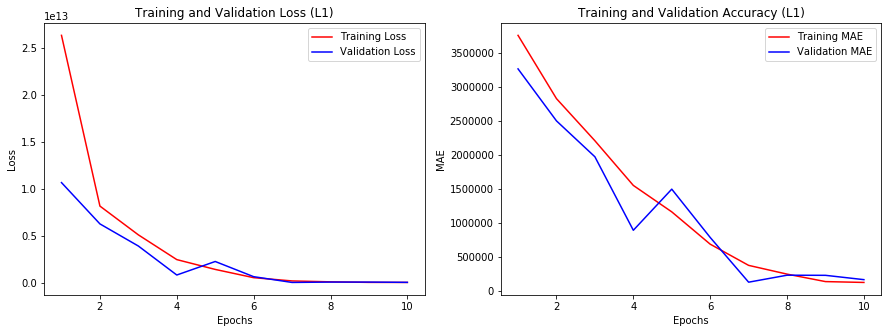

In [21]:
#Plot graph for L1 Reguarlization
history_dict = history.history

fig, (p1, p2) = plt.subplots(1, 2, figsize=(15,5))

p1.plot(x, history_dict['loss'], 'r', label='Training Loss')
p1.plot(x, history_dict['val_loss'], 'b', label='Validation Loss')
p1.set_title('Training and Validation Loss (L1)')
p1.set_xlabel('Epochs')
p1.set_ylabel('Loss')
p1.legend()

p2.plot(x, history_dict['mean_absolute_error'], 'r', label='Training MAE')
p2.plot(x, history_dict['val_mean_absolute_error'], 'b', label='Validation MAE')
p2.set_title('Training and Validation Accuracy (L1)')
p2.set_xlabel('Epochs')
p2.set_ylabel('MAE')
p2.legend()

plt.show()